In [2]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
import time
import sys
import datetime

import holidays
holidays = holidays.Brazil()

warnings.simplefilter(action='ignore', category=FutureWarning)

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [3]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [4]:
def read_data(input_file):
    df = pd.read_csv(input_file, parse_dates=['first_active_month'], nrows = 1000)
    df['first_active_month'] = pd.to_datetime(df['first_active_month'])
    df['elapsed_time'] = (datetime.datetime.today() - df['first_active_month']).dt.days
    return df
#_________________________________________
train = read_data('train.csv')
test = read_data('test.csv')
hist_trans = reduce_mem_usage(pd.read_csv('historical_transactions.csv', nrows = 10000))
new_merchant_trans = reduce_mem_usage(pd.read_csv('new_merchant_transactions.csv', nrows = 10000))

Mem. usage decreased to  0.57 Mb (46.4% reduction)
Mem. usage decreased to  0.57 Mb (46.4% reduction)


## Train and test files

In [5]:
e = pd.read_excel('Data_Dictionary.xlsx', sheet_name='train')
e[2:]

,train.csv,Unnamed: 1
2,card_id,Unique card identifier
3,first_active_month,"'YYYY-MM', month of first purchase"
4,feature_1,Anonymized card categorical feature
5,feature_2,Anonymized card categorical feature
6,feature_3,Anonymized card categorical feature
7,target,Loyalty numerical score calculated 2 months af...


In [6]:
train.info(), test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 7 columns):
first_active_month    1000 non-null datetime64[ns]
card_id               1000 non-null object
feature_1             1000 non-null int64
feature_2             1000 non-null int64
feature_3             1000 non-null int64
target                1000 non-null float64
elapsed_time          1000 non-null int64
dtypes: datetime64[ns](1), float64(1), int64(4), object(1)
memory usage: 54.8+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 6 columns):
first_active_month    1000 non-null datetime64[ns]
card_id               1000 non-null object
feature_1             1000 non-null int64
feature_2             1000 non-null int64
feature_3             1000 non-null int64
elapsed_time          1000 non-null int64
dtypes: datetime64[ns](1), int64(4), object(1)
memory usage: 47.0+ KB


(None, None)

In [7]:
train.describe()

,feature_1,feature_2,feature_3,target,elapsed_time
count,1000.000000,1000.000000,1000.00000,1000.000000,1000.000000
mean,3.030000,1.807000,0.52700,-0.591886,727.952000
std,1.142981,0.759162,0.49952,4.722386,286.965731
min,1.000000,1.000000,0.00000,-33.219281,408.000000
25%,2.000000,1.000000,0.00000,-0.820897,499.000000
50%,3.000000,2.000000,1.00000,0.056209,652.000000
75%,4.000000,2.000000,1.00000,0.824897,864.000000
max,5.000000,3.000000,1.00000,8.618037,2083.000000


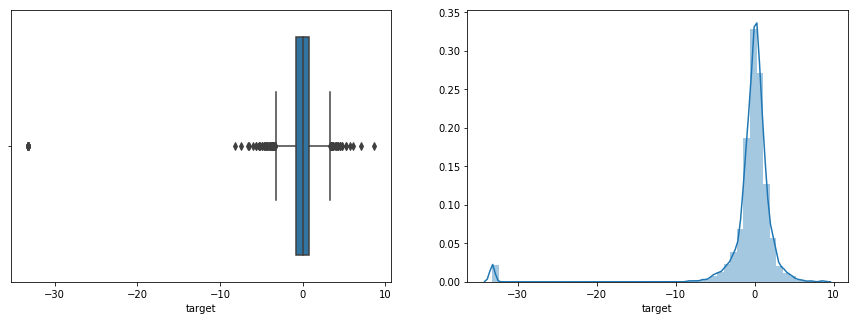

In [8]:
f, axes = plt.subplots(1, 2, figsize=(15,5))

# Tell pointplot to plot on ax1 with the ax argument
sns.boxplot(train['target'], data=train, ax=axes[0])
sns.distplot(train['target'], ax=axes[1])

plt.show()

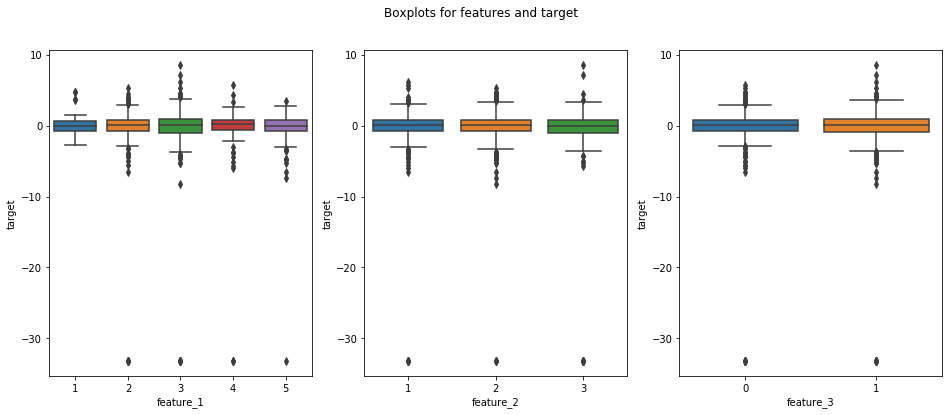

In [9]:
fig, ax = plt.subplots(1, 3, figsize = (16, 6))
plt.suptitle('Boxplots for features and target');
sns.boxplot(x="feature_1", y="target", data=train, ax=ax[0]);
sns.boxplot(x="feature_2", y="target", data=train, ax=ax[1]);
sns.boxplot(x="feature_3", y="target", data=train, ax=ax[2]);

In [10]:
def target_class(x):
    if -35 < x <= -30:
        return 'min_out'
    if -30 < x <= -10:
        return 'negative_out'
    if -10 < x <= 10:
        return 'normal'
    if 10 < x <= 30:
        return 'positive_out'

train['target_class'] = train['target'].apply(target_class)

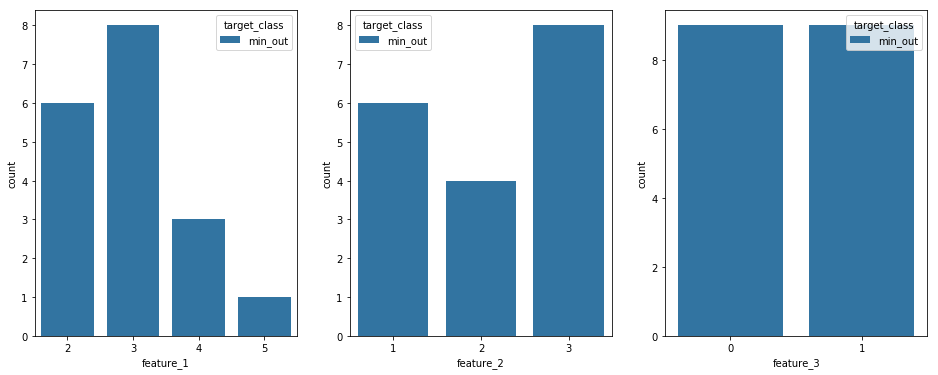

In [11]:
fig, ax = plt.subplots(1, 3, figsize = (16, 6));
sns.countplot(x="feature_1", hue="target_class", data=train[train['target_class'] != 'normal'], ax=ax[0])
sns.countplot(x="feature_2", hue="target_class", data=train[train['target_class'] != 'normal'], ax=ax[1])
sns.countplot(x="feature_3", hue ="target_class", data=train[train['target_class'] != 'normal'], ax=ax[2]);

In [12]:
print ('Main outlier is',train[train['target_class'] == 'min_out']['target'].mean())

Main outlier is -33.21928095


In [13]:
print('There are {0} samples with target lower than -20.'.format(train.loc[train.target < -20].shape[0]))
print('It is {0}% from all data.'.format(train.loc[train.target < -30].shape[0]*100/train.shape[0]))

print('std from the mean is {0}.'.format(train['target'].std()))
print('std without -33 is {0}.'.format(train[train['target_class'] != 'min_out']['target'].std()))
print('std without any outliers is {0}.'.format(train[train['target_class'] == 'normal']['target'].std()))

There are 18 samples with target lower than -20.
It is 1.8% from all data.
std from the mean is 4.722385935165558.
std without -33 is 1.679020896753032.
std without any outliers is 1.679020896753032.


## Historical transaction file

In [14]:
e = pd.read_excel('Data_Dictionary.xlsx', sheet_name='history')
e[2:]

,historical_transactions.csv,Unnamed: 1
2,card_id,Card identifier
3,month_lag,month lag to reference date
4,purchase_date,Purchase date
5,authorized_flag,"Y' if approved, 'N' if denied"
6,category_3,"Installements: 0, 1, <1, >1"
7,installments,number of installments of purchase
8,category_1,non Brasília: Y
9,merchant_category_id,Merchant category identifier (anonymized )
10,subsector_id,Merchant category group identifier (anonymized )
11,merchant_id,Merchant identifier (anonymized)


### Autorization

At average 94.4400% transactions are authorized


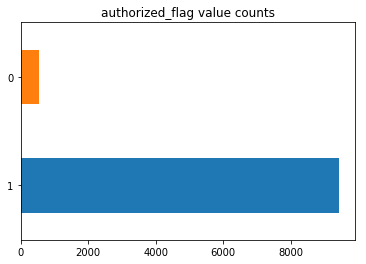

In [15]:
# let's convert the authorized_flag to a binary value.
hist_trans['authorized_flag'] = hist_trans['authorized_flag'].apply(lambda x: 1 if x == 'Y' else 0)
print(f"At average {hist_trans['authorized_flag'].mean() * 100:.4f}% transactions are authorized")
hist_trans['authorized_flag'].value_counts().plot(kind='barh', title='authorized_flag value counts');

In [16]:
autorized_card_rate = hist_trans.groupby(['card_id'])['authorized_flag'].mean().sort_values()
autorized_card_rate.head()

card_id
C_ID_536bff298a    0.548387
C_ID_ca09e9cea5    0.820000
C_ID_190bd090c9    0.828571
C_ID_76ac7d7a48    0.833333
C_ID_12b7811978    0.878049
Name: authorized_flag, dtype: float64

### Installements

In category 3 A : 0 installement, B : 1, C:others


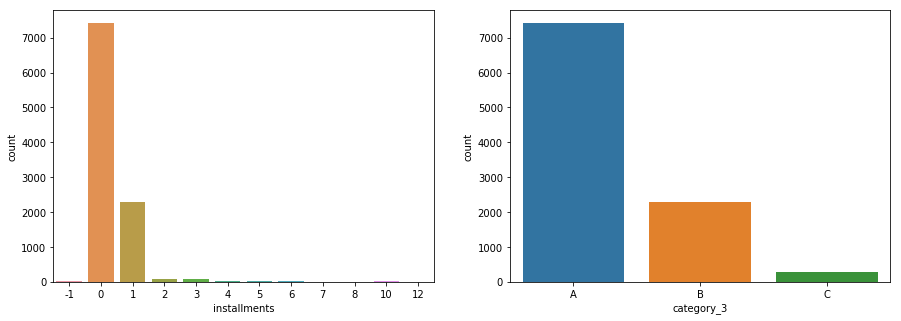

In [17]:
fig, ax = plt.subplots(1, 2, figsize = (15, 5));
sns.countplot(hist_trans['installments'], ax=ax[0]);
sns.countplot(hist_trans['category_3'], ax=ax[1]);
print ('In category 3 A : 0 installement, B : 1, C:others')

In [18]:
hist_trans[hist_trans['installments']==0].shape[0], hist_trans[hist_trans['category_3'] =='A'].shape[0],\
hist_trans[hist_trans['installments']==1].shape[0], hist_trans[hist_trans['category_3'] =='B'].shape[0]

(7418, 7418, 2291, 2291)

## month_lag

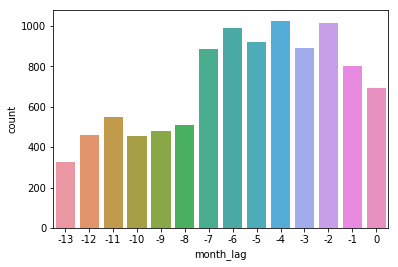

In [20]:
sns.countplot(hist_trans['month_lag'])

## purchase_date

In [21]:
def date_transform(df, date):
    df[date] = pd.to_datetime(df[date])
    df['year'] = df[date].dt.year
    df['month'] = df[date].dt.month
    df['dayofweek'] = df[date].dt.dayofweek
    df['hour'] = df[date].dt.hour
    df['weekend'] = [1 if x>=5 else 0 for x in df['dayofweek']]

In [22]:
date_transform(hist_trans, 'purchase_date')

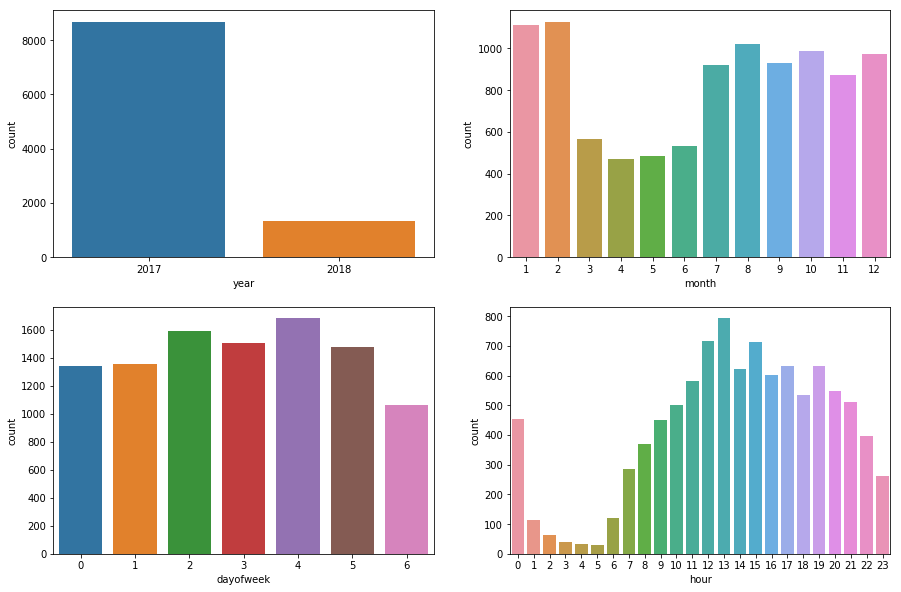

In [23]:
fig, ax = plt.subplots(2, 2, figsize = (15, 10));
sns.countplot(hist_trans['year'], ax = ax[0,0]);
sns.countplot(hist_trans['month'], ax = ax[0,1]);
sns.countplot(hist_trans['dayofweek'], ax = ax[1,0]);
sns.countplot(hist_trans['hour'], ax = ax[1,1]);

In [24]:
def holydays(df, date):
    df[date] = pd.to_datetime(df[date])
    df[date+'_ymd'] = df[date].map(lambda x: x.strftime('%Y, %m, %d'))
    df['holidays'] = df[date+'_ymd'].apply(lambda x: x in holidays)
    df['holidays'] = df['holidays'].map({True:1, False:0}) 
holydays(hist_trans, 'purchase_date')

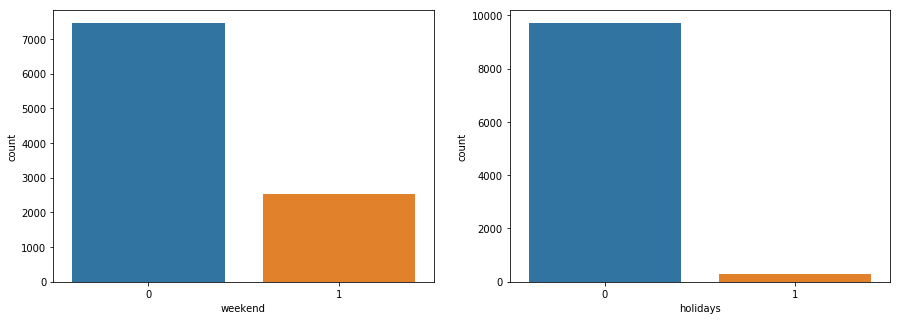

In [25]:
fig, ax = plt.subplots(1, 2, figsize = (15, 5));
sns.countplot(hist_trans['weekend'], ax = ax[0]);
sns.countplot(hist_trans['holidays'], ax = ax[1]);

## Geography

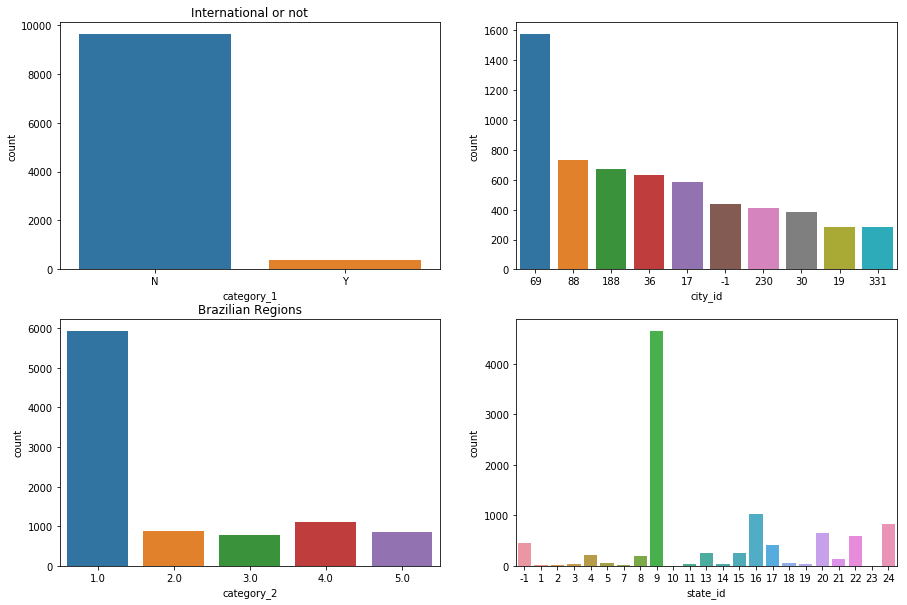

In [26]:
fig, ax = plt.subplots(2, 2, figsize = (15, 10));
sns.countplot(hist_trans['category_1'], ax = ax[0,0]).set_title("International or not");
sns.countplot(x ='city_id', data = hist_trans, order = hist_trans['city_id'].value_counts().head(10).index, ax = ax[0,1]);
sns.countplot(hist_trans['category_2'], ax = ax[1,0]).set_title("Brazilian Regions");
sns.countplot(hist_trans['state_id'], ax = ax[1,1]);

## Merchants 

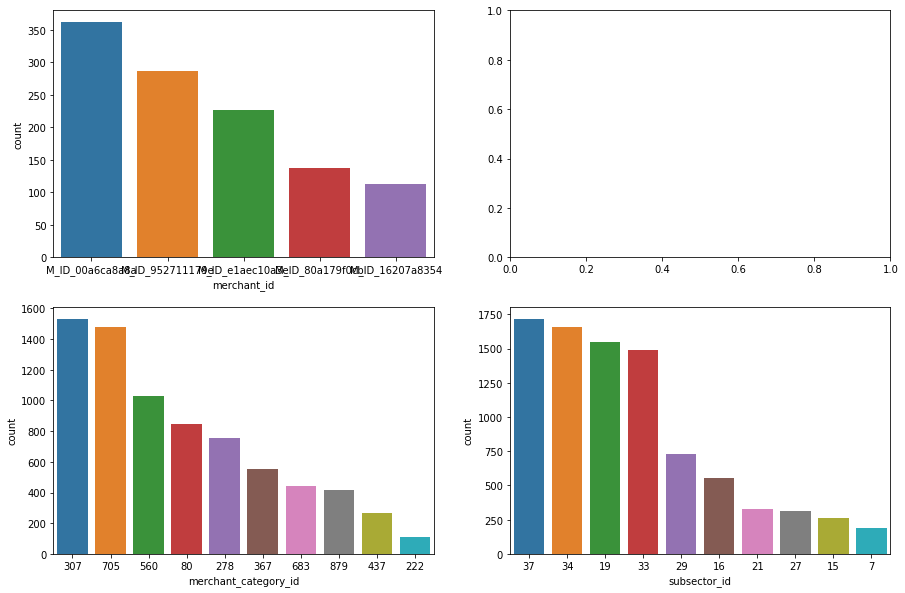

In [27]:
fig, ax = plt.subplots(2, 2, figsize = (15, 10));
sns.countplot(x ='merchant_id', data = hist_trans, order = hist_trans['merchant_id'].value_counts().head(5).index, ax = ax[0,0]);
sns.countplot(x ='merchant_category_id', data = hist_trans, order = hist_trans['merchant_category_id'].value_counts().head(10).index, ax = ax[1,0]);
sns.countplot(x ='subsector_id', data = hist_trans, order = hist_trans['subsector_id'].value_counts().head(10).index, ax = ax[1,1]);

## purchase_amount vs. other parameters

purchase_amount distribution

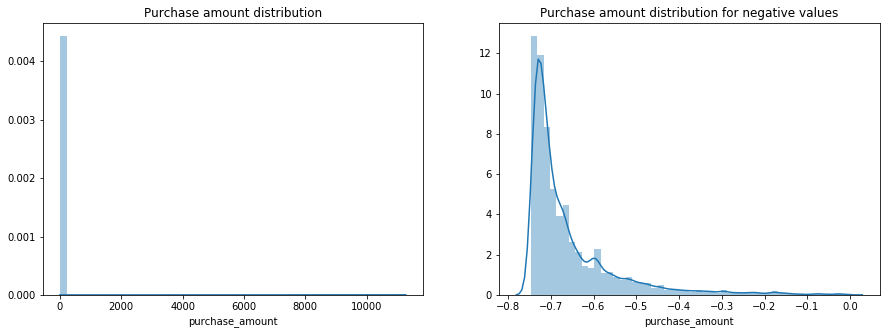

In [28]:
fig, ax = plt.subplots(1, 2, figsize = (15, 5));
sns.distplot(hist_trans['purchase_amount'], ax = ax[0]).set_title("Purchase amount distribution");
sns.distplot(hist_trans[hist_trans['purchase_amount']<0]['purchase_amount'], ax = ax[1]).set_title("Purchase amount distribution for negative values");

### autorization

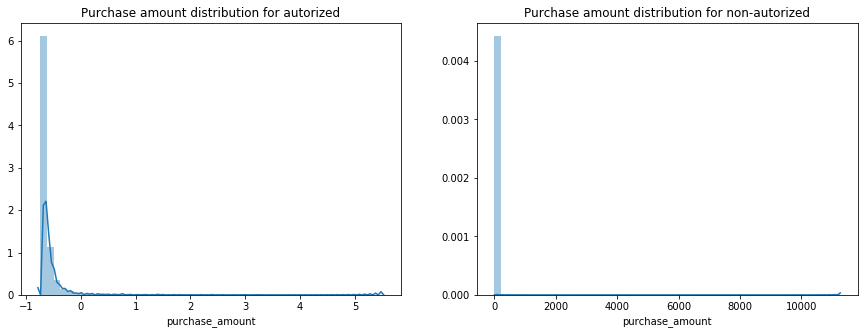

In [29]:
fig, ax = plt.subplots(1, 2, figsize = (15, 5));
sns.distplot(hist_trans[hist_trans['authorized_flag'] == 1]['purchase_amount'], ax = ax[0]).\
set_title("Purchase amount distribution for autorized");
#plt.xlim(left=-2, right=2)
sns.distplot(hist_trans[hist_trans['authorized_flag'] == 0]['purchase_amount'], ax = ax[1]).\
set_title("Purchase amount distribution for non-autorized");

In [30]:
print(f"Mean purchase amount of autorized transaction is {hist_trans[hist_trans['authorized_flag'] == 1]['purchase_amount'].mean()}")
print(f"Median purchase amount of autorized transaction is {hist_trans[hist_trans['authorized_flag'] == 1]['purchase_amount'].median()}")
print(f"Mean purchase amount of non-autorized transaction is {hist_trans[hist_trans['authorized_flag'] == 0]['purchase_amount'].mean()}")
print(f"Median purchase amount of non-autorized transaction is {hist_trans[hist_trans['authorized_flag'] == 0]['purchase_amount'].median()}")
print(f"{hist_trans[(hist_trans['authorized_flag'] == 0)&(hist_trans['purchase_amount'] > 6)].shape[0]*100/hist_trans[hist_trans['authorized_flag'] == 0].shape[0]}% of non-autorized transactions larger than 6")

Mean purchase amount of autorized transaction is -0.63037109375
Median purchase amount of autorized transaction is -0.69970703125
Mean purchase amount of non-autorized transaction is 19.78125
Median purchase amount of non-autorized transaction is -0.69140625
0.3597122302158273% of non-autorized transactions larger than 6


In [31]:
hist_trans_autorized = hist_trans[hist_trans['authorized_flag'] == 1]
hist_trans_autorized.head()

,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id,year,month,dayofweek,hour,weekend,purchase_date_ymd,holidays
0,1,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_e020e9b302,-8,-0.703125,2017-06-25 15:33:07,1.0,16,37,2017,6,6,15,1,"2017, 06, 25",0
1,1,C_ID_4e6213e9bc,88,N,0,A,367,M_ID_86ec983688,-7,-0.732910,2017-07-15 12:10:45,1.0,16,16,2017,7,5,12,1,"2017, 07, 15",0
2,1,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_979ed661fc,-6,-0.720215,2017-08-09 22:04:29,1.0,16,37,2017,8,2,22,0,"2017, 08, 09",0
3,1,C_ID_4e6213e9bc,88,N,0,A,560,M_ID_e6d5ae8ea6,-5,-0.735352,2017-09-02 10:06:26,1.0,16,34,2017,9,5,10,1,"2017, 09, 02",0
4,1,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_e020e9b302,-11,-0.722656,2017-03-10 01:14:19,1.0,16,37,2017,3,4,1,0,"2017, 03, 10",0


### installement catergories

In [32]:
hist_trans_autorized['purchase_amount'].groupby(hist_trans_autorized['category_3']).mean(),\
hist_trans_autorized['purchase_amount'].groupby(hist_trans_autorized['category_3']).sum()

(category_3
 A   -0.658691
 B   -0.607422
 C   -0.016983
 Name: purchase_amount, dtype: float16, category_3
 A   -4664.000000
 B   -1279.000000
 C      -4.109375
 Name: purchase_amount, dtype: float16)

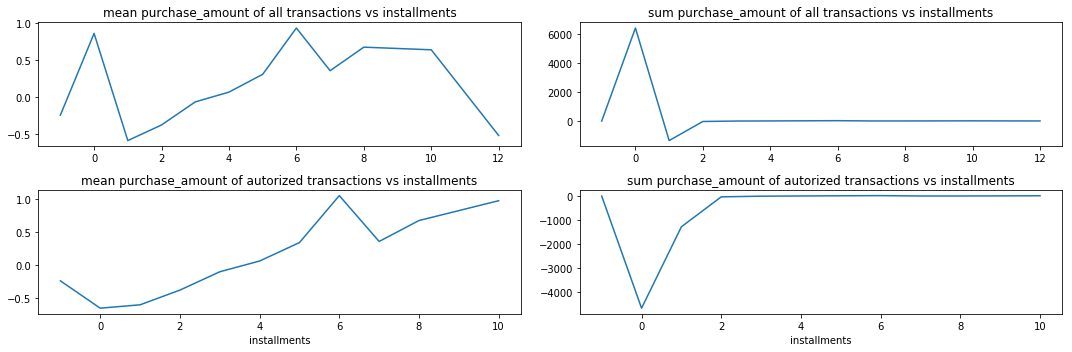

In [33]:
fig = plt.figure(figsize = (15, 5))
plt.tight_layout()
plt.subplot(2, 2, 1)
plt.plot(hist_trans['purchase_amount'].groupby(hist_trans['installments']).mean())
plt.title('mean purchase_amount of all transactions vs installments')
plt.subplot(2, 2, 2)
plt.plot(hist_trans['purchase_amount'].groupby(hist_trans['installments']).sum())
plt.title('sum purchase_amount of all transactions vs installments');
plt.subplot(2, 2, 3)
plt.plot(hist_trans_autorized['purchase_amount'].groupby(hist_trans_autorized['installments']).mean())
plt.xlabel('installments')
plt.title('mean purchase_amount of autorized transactions vs installments')
plt.subplot(2, 2, 4)
plt.plot(hist_trans_autorized['purchase_amount'].groupby(hist_trans_autorized['installments']).sum())
plt.xlabel('installments')
plt.title('sum purchase_amount of autorized transactions vs installments');
plt.tight_layout()

### month_lag'

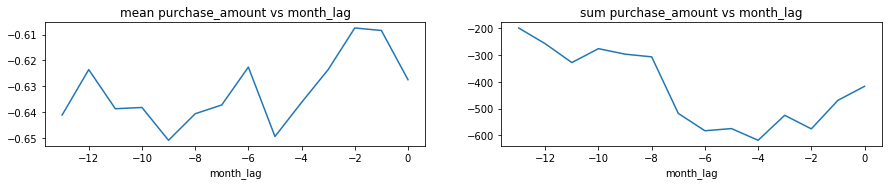

In [34]:
fig = plt.figure(figsize = (15, 5))
plt.subplot(2, 2, 1)
plt.plot(hist_trans_autorized['purchase_amount'].groupby(hist_trans_autorized['month_lag']).mean())
plt.xlabel('month_lag')
plt.title('mean purchase_amount vs month_lag')
plt.subplot(2, 2, 2)
plt.plot(hist_trans_autorized['purchase_amount'].groupby(hist_trans_autorized['month_lag']).sum())
plt.xlabel('month_lag')
plt.title('sum purchase_amount vs month_lag');

### purchase time

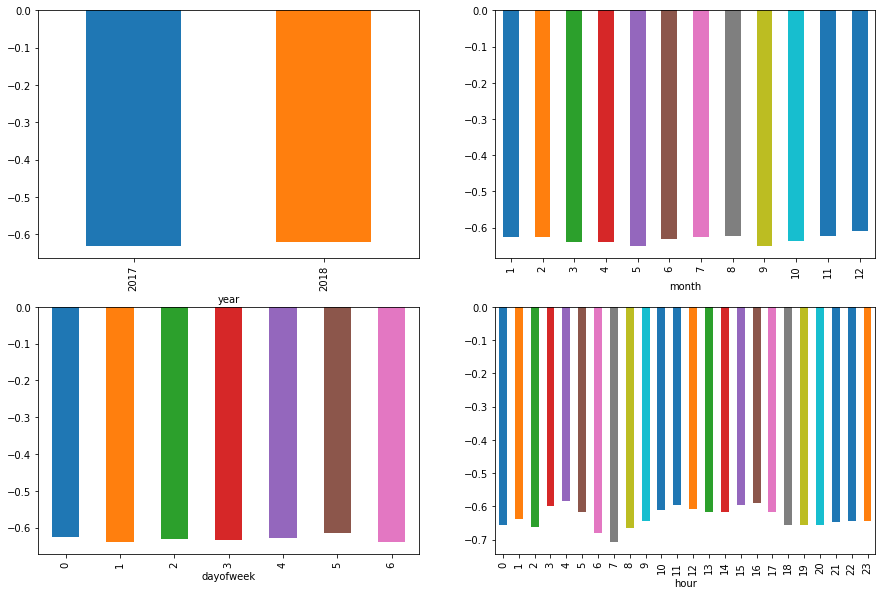

In [35]:
fig, axes = plt.subplots(2, 2, figsize = (15, 10));
hist_trans_autorized['purchase_amount'].groupby(hist_trans_autorized['year']).mean().plot(ax=axes[0,0], kind = 'bar')
hist_trans_autorized['purchase_amount'].groupby(hist_trans_autorized['month']).mean().plot(ax=axes[0,1], kind = 'bar')
hist_trans_autorized['purchase_amount'].groupby(hist_trans_autorized['dayofweek']).mean().plot(ax=axes[1,0], kind = 'bar')
hist_trans_autorized['purchase_amount'].groupby(hist_trans_autorized['hour']).mean().plot(ax=axes[1,1], kind = 'bar');

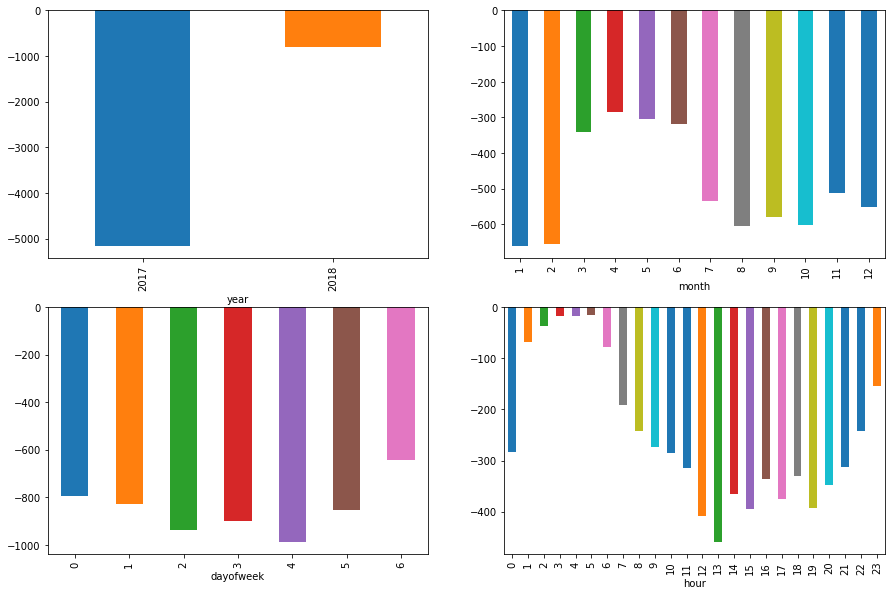

In [50]:
fig, axes = plt.subplots(2, 2, figsize = (15, 10));
hist_trans_autorized['purchase_amount'].groupby(hist_trans_autorized['year']).sum().plot(ax=axes[0,0], kind = 'bar')
hist_trans_autorized['purchase_amount'].groupby(hist_trans_autorized['month']).sum().plot(ax=axes[0,1], kind = 'bar')
hist_trans_autorized['purchase_amount'].groupby(hist_trans_autorized['dayofweek']).sum().plot(ax=axes[1,0], kind = 'bar')
hist_trans_autorized['purchase_amount'].groupby(hist_trans_autorized['hour']).sum().plot(ax=axes[1,1], kind = 'bar');

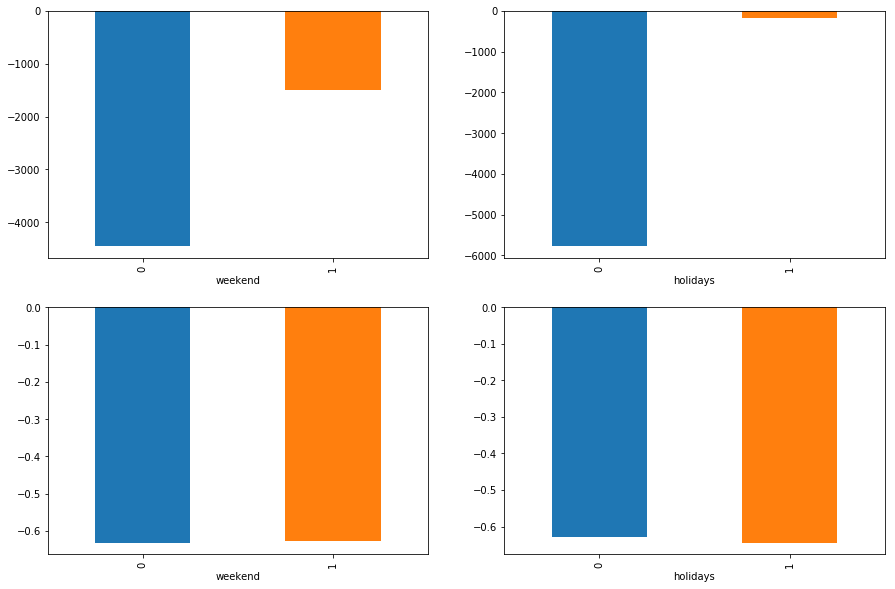

In [37]:
fig, axes = plt.subplots(2, 2, figsize = (15, 10));
hist_trans_autorized['purchase_amount'].groupby(hist_trans_autorized['weekend']).sum().plot(ax=axes[0,0], kind = 'bar')
hist_trans_autorized['purchase_amount'].groupby(hist_trans_autorized['holidays']).sum().plot(ax=axes[0,1], kind = 'bar')
hist_trans_autorized['purchase_amount'].groupby(hist_trans_autorized['weekend']).mean().plot(ax=axes[1,0], kind = 'bar')
hist_trans_autorized['purchase_amount'].groupby(hist_trans_autorized['holidays']).mean().plot(ax=axes[1,1], kind = 'bar');

### Geography

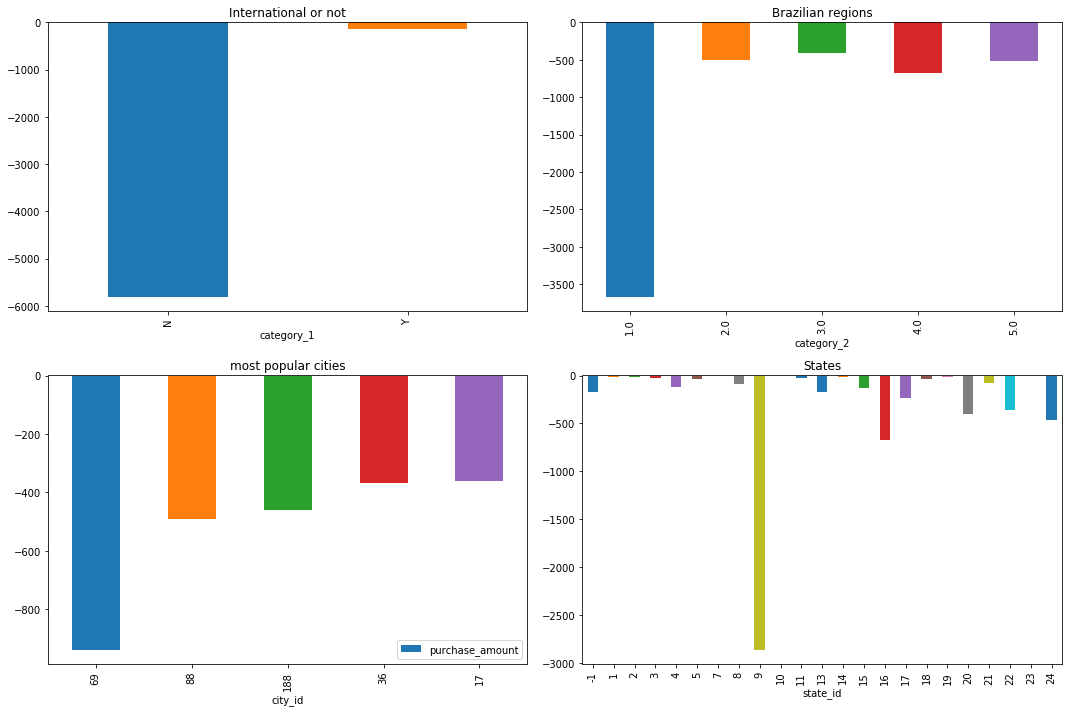

In [51]:
fig, axes = plt.subplots(2, 2, figsize = (15, 10));
hist_trans_autorized['purchase_amount'].groupby(hist_trans_autorized['category_1']).sum().plot(ax=axes[0,0], kind = 'bar', title = 'International or not')
hist_trans_autorized['purchase_amount'].groupby(hist_trans_autorized['category_2']).sum().plot(ax=axes[0,1], kind = 'bar', title = 'Brazilian regions')
hist_trans_autorized['purchase_amount'].groupby(hist_trans_autorized['city_id']).sum().\
reset_index().sort_values('purchase_amount', ascending=True).head().plot(ax=axes[1,0],x = 'city_id', y = 'purchase_amount', kind = 'bar', title = 'most popular cities')
hist_trans_autorized['purchase_amount'].groupby(hist_trans_autorized['state_id']).sum().plot(ax=axes[1,1], kind = 'bar', title = 'States');
plt.tight_layout()

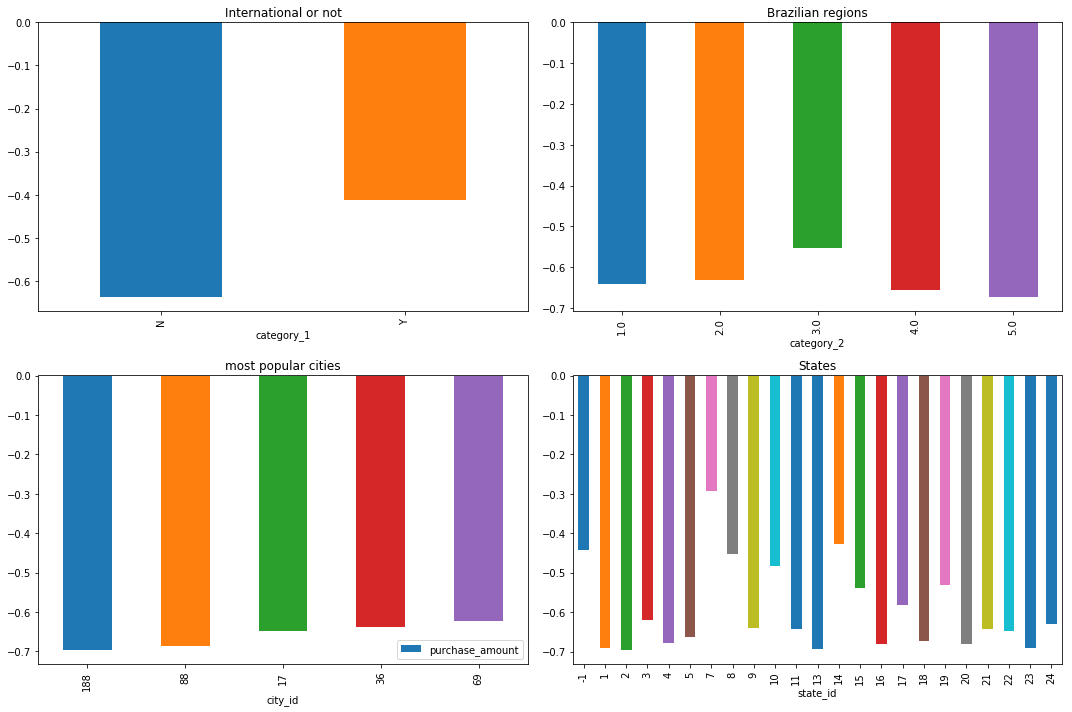

In [52]:
fig, axes = plt.subplots(2, 2, figsize = (15, 10));
hist_trans_autorized['purchase_amount'].groupby(hist_trans_autorized['category_1']).mean().plot(ax=axes[0,0], kind = 'bar', title = 'International or not')
hist_trans_autorized['purchase_amount'].groupby(hist_trans_autorized['category_2']).mean().plot(ax=axes[0,1], kind = 'bar', title = 'Brazilian regions')
hist_trans_autorized[hist_trans_autorized['city_id'].isin([69, 88, 188, 36, 17])]['purchase_amount'].groupby(hist_trans_autorized['city_id']).mean().\
reset_index().sort_values('purchase_amount', ascending=True).head().plot(ax=axes[1,0],x = 'city_id', y = 'purchase_amount', kind = 'bar', title = 'most popular cities')
hist_trans_autorized['purchase_amount'].groupby(hist_trans_autorized['state_id']).mean().plot(ax=axes[1,1], kind = 'bar', title = 'States');
plt.tight_layout()

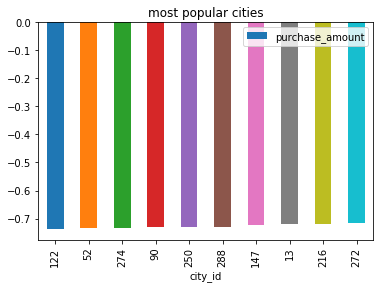

In [64]:
hist_trans_autorized['purchase_amount'].groupby(hist_trans_autorized['city_id']).mean().\
reset_index().sort_values('purchase_amount', ascending=True).head(10).plot(x = 'city_id', y = 'purchase_amount', kind = 'bar', title = 'most popular cities')

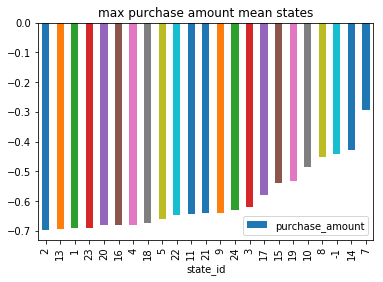

In [48]:
hist_trans_autorized['purchase_amount'].groupby(hist_trans_autorized['state_id']).mean().\
reset_index().sort_values('purchase_amount', ascending=True).plot(x = 'state_id', y = 'purchase_amount', kind = 'bar', title = 'max purchase amount mean states')

In [69]:
#most frequent_states
hist_trans_autorized.groupby('card_id')['state_id'].agg(lambda x: x.value_counts().index[0]).head()

card_id
C_ID_058b254a5b     9
C_ID_0d6b8c2d0f     9
C_ID_0e171c1b48    13
C_ID_12b7811978     5
C_ID_190bd090c9     3
Name: state_id, dtype: int8

In [70]:
#most frequent_states
hist_trans_autorized.groupby('card_id')['city_id'].agg(lambda x: x.value_counts().index[0]).head()

card_id
C_ID_058b254a5b    233
C_ID_0d6b8c2d0f     19
C_ID_0e171c1b48    277
C_ID_12b7811978     57
C_ID_190bd090c9    286
Name: city_id, dtype: int16

### Merchants

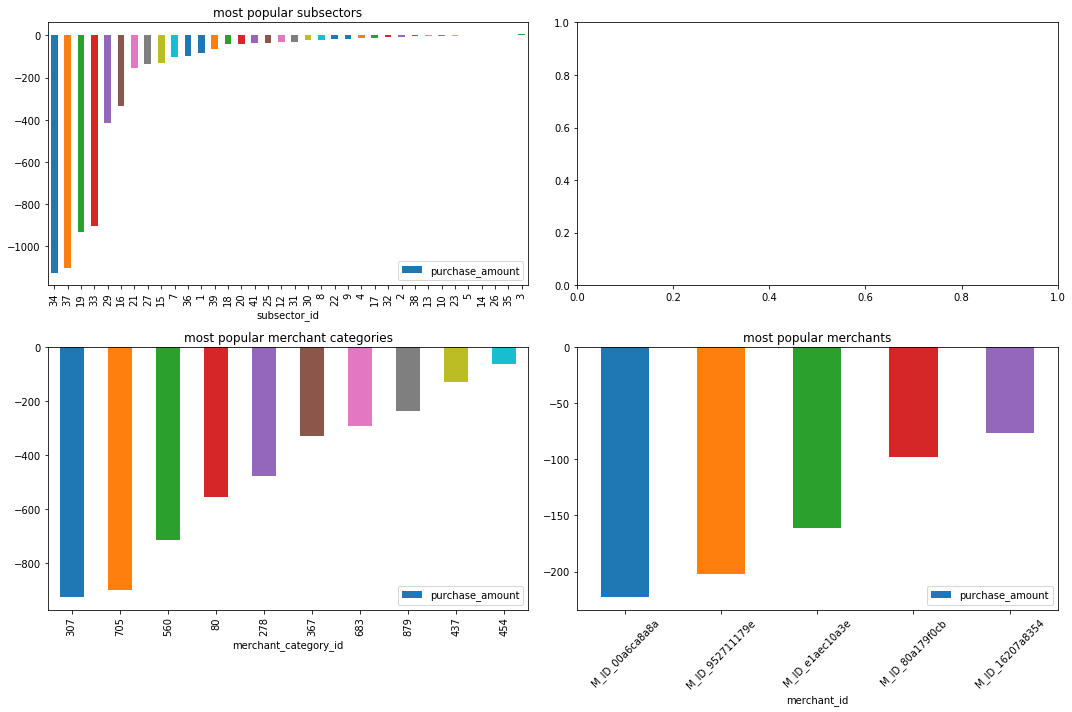

In [71]:
fig, axes = plt.subplots(2, 2, figsize = (15, 10));
hist_trans_autorized['purchase_amount'].groupby(hist_trans_autorized['subsector_id']).sum().\
reset_index().sort_values('purchase_amount', ascending=True).plot(ax=axes[0,0],x = 'subsector_id', y = 'purchase_amount', kind = 'bar', title = 'most popular subsectors')
hist_trans_autorized['purchase_amount'].groupby(hist_trans_autorized['merchant_category_id']).sum().\
reset_index().sort_values('purchase_amount', ascending=True).head(10).plot(ax=axes[1,0],x = 'merchant_category_id', y = 'purchase_amount', kind = 'bar', title = 'most popular merchant categories')
hist_trans_autorized['purchase_amount'].groupby(hist_trans_autorized['merchant_id']).sum().\
reset_index().sort_values('purchase_amount', ascending=True).head().plot(ax=axes[1,1],x = 'merchant_id', y = 'purchase_amount', kind = 'bar', title = 'most popular merchants')
plt.xticks(rotation = 45)
plt.tight_layout();

In [1]:
fig, ax = plt.subplots(2, 2, figsize = (15, 10));
sns.countplot(x ='merchant_id', data = hist_trans, order = hist_trans['merchant_id'].value_counts().head(5).index, ax = ax[1,1]);
sns.countplot(x ='merchant_category_id', data = hist_trans, order = hist_trans['merchant_category_id'].value_counts().head(10).index, ax = ax[1,0]);
sns.countplot(x ='subsector_id', data = hist_trans, order = hist_trans['subsector_id'].value_counts().head(10).index, ax = ax[0,0])
plt.xticks(rotation = 45)
plt.tight_layout();

NameError: name 'plt' is not defined

In [228]:
hist_trans['subsector_id'].value_counts().head(5).index

Int64Index([37, 34, 19, 33, 29], dtype='int64')

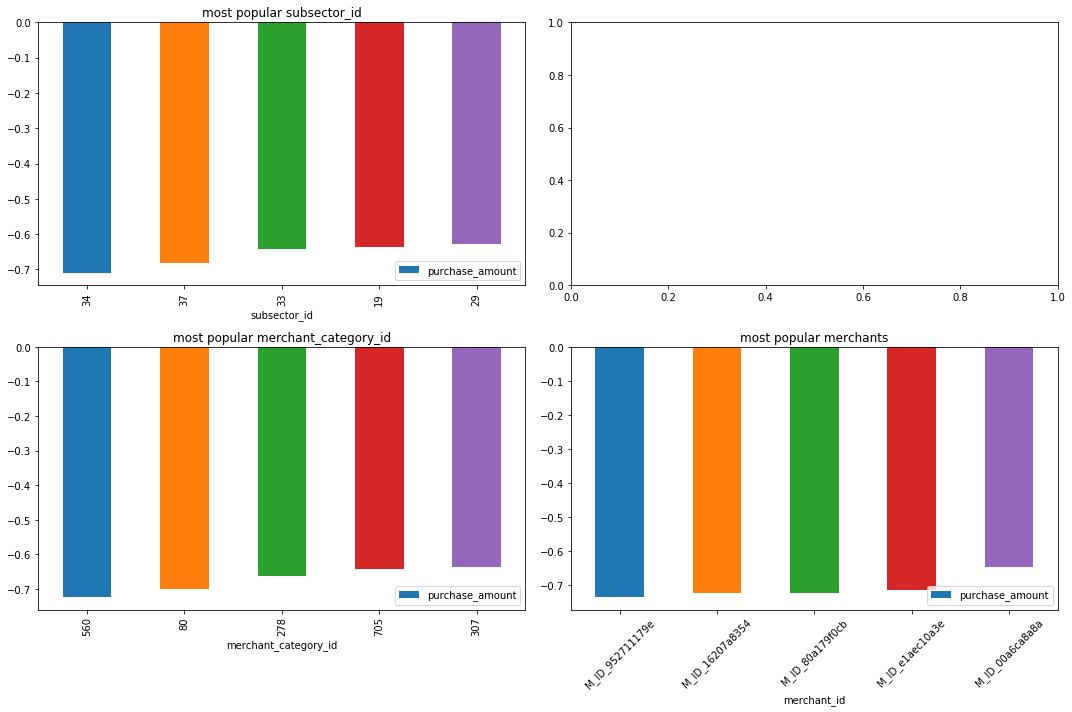

In [49]:
fig, ax = plt.subplots(2, 2, figsize = (15, 10));
hist_trans_autorized[hist_trans_autorized['subsector_id'].isin([37, 34, 19, 33, 29])]['purchase_amount'].groupby(hist_trans_autorized['subsector_id']).mean().\
reset_index().sort_values('purchase_amount', ascending=True).plot(ax = ax[0,0], x = 'subsector_id', y = 'purchase_amount', kind = 'bar', title = 'most popular subsector_id')
hist_trans_autorized[hist_trans_autorized['merchant_category_id'].isin([307, 705, 560, 80, 278])]['purchase_amount'].groupby(hist_trans_autorized['merchant_category_id']).mean().\
reset_index().sort_values('purchase_amount', ascending=True).plot(ax = ax[1,0], x = 'merchant_category_id', y = 'purchase_amount', kind = 'bar', title = 'most popular merchant_category_id')
hist_trans_autorized[hist_trans_autorized['merchant_id'].isin(['M_ID_00a6ca8a8a', 'M_ID_952711179e', 'M_ID_e1aec10a3e', 'M_ID_80a179f0cb', 'M_ID_16207a8354'])]['purchase_amount'].groupby(hist_trans_autorized['merchant_id']).mean().\
reset_index().sort_values('purchase_amount', ascending=True).plot(ax = ax[1,1], x = 'merchant_id', y = 'purchase_amount', kind = 'bar', title = 'most popular merchants')
plt.xticks(rotation = 45)
plt.tight_layout();